In [17]:
!pip install pims_nd2

2430.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 4.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pims_nd2: filename=pims_nd2-1.1-py3-none-any.whl size=19778382 sha256=9565dedda9cd6296a653167ac95803cdf0a97d8bea62a14052905f4e18cbeec3
  Stored in directory: /Users/user/Library/Caches/pip/wheels/57/c3/f7/800b88f7584a1ad067d2ebe91e2edbc4c9cf3c603a3b0251ac
Successfully built pims_nd2


In [ ]:
from cellpose import models, io
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave

Total frames: 37


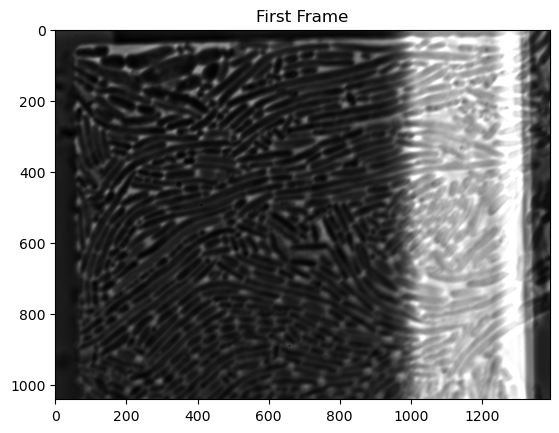

In [28]:

from nd2reader import ND2Reader

# Open the ND2 file
nd2_file = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"

# Load the ND2 file (without closing it immediately)
images = ND2Reader(nd2_file)

# Check the total number of frames
print(f"Total frames: {len(images)}")

# Display the first frame
plt.imshow(images[0], cmap="gray")
plt.title("First Frame")
plt.show()

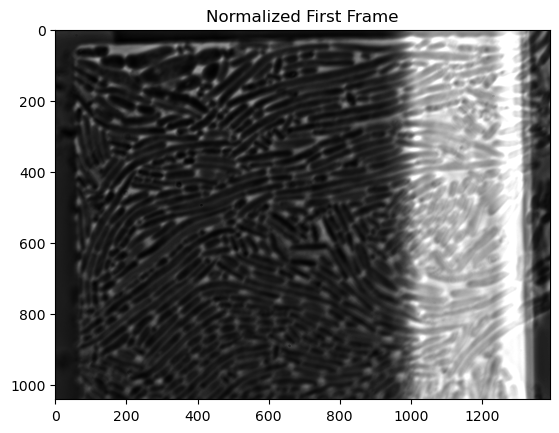

In [29]:
# Normalize the first frame
first_frame = images[0] 
normalized_frame = (first_frame - np.min(first_frame)) / (np.max(first_frame) - np.min(first_frame))

plt.imshow(normalized_frame, cmap="gray")
plt.title("Normalized First Frame")
plt.show()

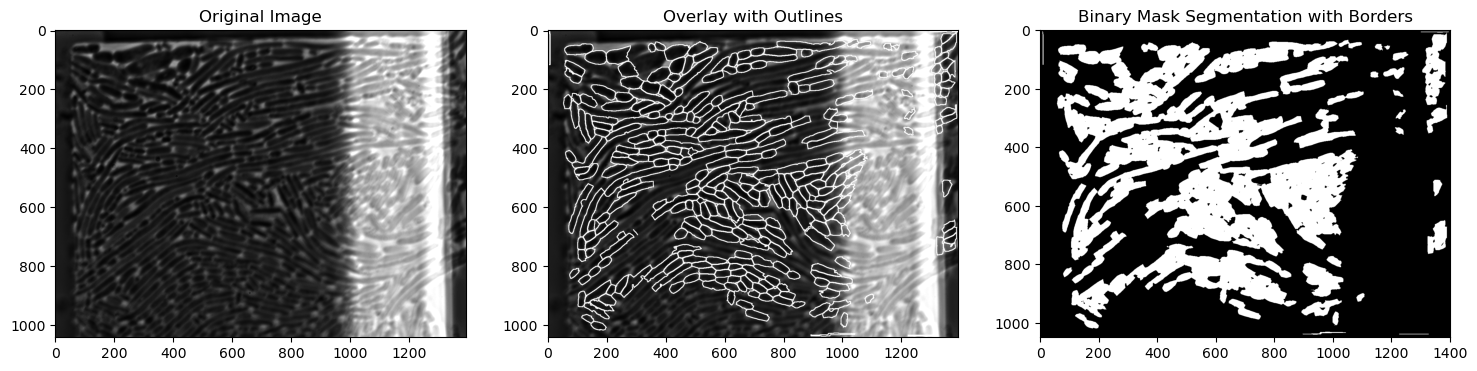

In [ ]:
from cellpose import models, utils
from skimage.restoration import richardson_lucy
from scipy.ndimage import gaussian_filter, binary_dilation
from nd2reader import ND2Reader
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt


def load_nd2_file(nd2_file):
    """
    Load the first frame of an ND2 file and normalize it.

    Parameters:
        nd2_file (str): Path to the ND2 file.

    Returns:
        np.ndarray: Normalized frame from the ND2 file.
    """
    with ND2Reader(nd2_file) as images:
        first_frame = images[0]
        normalized_frame = (first_frame - np.min(first_frame)) / (np.max(first_frame) - np.min(first_frame))
    return normalized_frame


def preprocess_image(image):
    """
    Preprocess an image by applying Gaussian blur, CLAHE, and Richardson-Lucy deblurring.

    Parameters:
        image (np.ndarray): Input image.

    Returns:
        np.ndarray: Preprocessed image.
    """
    denoised_frame = gaussian_filter(normalized_frame, sigma=1)

    # Apply CLAHE to improve contrast
    clahe = exposure.equalize_adapthist(denoised_frame, clip_limit=0.03)

    # Step 3: Deblur the image
    psf = np.ones((5, 5)) / 25  # Example PSF
    deblurred_frame = richardson_lucy(denoised_frame, psf, num_iter=30)

    return deblurred_frame


def segment_image(deblurred_frame, model_type="bact_phase_cp3"):
    """
    Segment the preprocessed image using a Cellpose model.

    Parameters:
        image (np.ndarray): Preprocessed image.
        model_type (str): Type of Cellpose model to use.

    Returns:
        tuple: Masks, flows, and styles from the Cellpose model.
    """
    model = models.CellposeModel(model_type=model_type)

    # Step 5: Apply the model to the preprocessed frame
    masks, flows, styles = model.eval(deblurred_frame, diameter=None, channels=[0, 0])
    return masks, flows, styles


def visualize_results(normalized_frame, masks):
    """
    Visualize the original image, overlay with outlines, and binary mask segmentation with borders.

    Parameters:
        normalized_frame (np.ndarray): Original normalized image.
        masks (np.ndarray): Segmentation masks.
    """
    outlines = utils.masks_to_outlines(masks)
    thick_outlines = binary_dilation(outlines, structure=np.ones((3, 3)))
    overlay = normalized_frame.copy()
    overlay[thick_outlines] = 1  # Set outline pixels to white
    
    

    # Generate binary mask
    binary_mask = masks > 0

    # Binary mask with borders
    binary_mask_with_borders = utils.masks_to_outlines(masks)
    binary_mask_display = binary_mask.copy()
    binary_mask_display[binary_mask_with_borders] = 0  # Set border pixels to black
    binary_mask_display = np.pad(binary_mask_display, pad_width=5, mode='constant', constant_values=0)

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax = ax.ravel()

    # Original Image
    ax[0].imshow(normalized_frame, cmap="gray")
    ax[0].set_title("Original Image")

    # Overlay with Outlines
    ax[1].imshow(overlay, cmap="gray")
    ax[1].set_title("Overlay with Outlines")

    # Binary Mask Segmentation with Borders
    ax[2].imshow(binary_mask_display, cmap="gray")
    ax[2].set_title("Binary Mask Segmentation with Borders")

    plt.show()


# Example Usage
if __name__ == "__main__":
    # Step 1: Load the ND2 file
    nd2_file = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"
    normalized_frame = load_nd2_file(nd2_file)

    # Step 2: Preprocess the image
    preprocessed_frame = preprocess_image(normalized_frame)

    # Step 3: Segment the image
    masks, flows, styles = segment_image(preprocessed_frame)

    # Step 4: Visualize the results
    visualize_results(normalized_frame, masks)


In [56]:
from cellpose import models
print(models.MODEL_NAMES)
model = models.CellposeModel(model_type="deepbacs_cp3")

['cyto3', 'nuclei', 'cyto2_cp3', 'tissuenet_cp3', 'livecell_cp3', 'yeast_PhC_cp3', 'yeast_BF_cp3', 'bact_phase_cp3', 'bact_fluor_cp3', 'deepbacs_cp3', 'cyto2', 'cyto', 'CPx', 'transformer_cp3', 'neurips_cellpose_default', 'neurips_cellpose_transformer', 'neurips_grayscale_cyto2', 'CP', 'CPx', 'TN1', 'TN2', 'TN3', 'LC1', 'LC2', 'LC3', 'LC4']
